In [1]:
import pandas as pd
import numpy as np
from collections import Counter 
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv("../input/flickr8k/captions.txt", sep=',')
print(len(df))
display(df.head(3))

40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .


In [3]:
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

In [4]:
df['cleaned_caption'] = df['caption'].apply(lambda caption : ['<start>'] + [word.lower() if word.isalpha() else '' for word in caption.split(" ")] + ['<end>'])
df['cleaned_caption']  = df['cleaned_caption'].apply(lambda x : remove_single_char_word(x))

In [5]:
df['seq_len'] = df['cleaned_caption'].apply(lambda x : len(x))
max_seq_len = df['seq_len'].max()
print(max_seq_len)

33


In [6]:
df.drop(['seq_len'], axis = 1, inplace = True)
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)) )

In [7]:
display(df.head(2))

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"


In [8]:
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)

In [9]:
print(len(word_dict))
print(word_dict[:5])

8360
['<pad>', '<start>', '<end>', 'in', 'the']


In [10]:
vocab_size = len(word_dict)
print(vocab_size)

8360


In [11]:
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

8360 8360


In [12]:
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )

In [13]:
display(df.head(2))

,image,caption,cleaned_caption,text_seq
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 41, 3, 89, 168, 6, 118, 52, 392, 11, 389, 3, 27, 5075, 690, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 18, 311, 63, 192, 116, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [14]:
df = df.sort_values(by = 'image')
train = df.iloc[:int(0.9*len(df))]
valid = df.iloc[int(0.9*len(df)):]

In [15]:
print(len(train), train['image'].nunique())
print(len(valid), valid['image'].nunique())

36409 7282
4046 810


In [16]:
train_samples = len(train)
print(train_samples)

36409


In [17]:
unq_train_imgs = train[['image']].drop_duplicates()
unq_valid_imgs = valid[['image']].drop_duplicates()

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
class extractImageFeatureResNetDataSet():
    def __init__(self, data):
        self.data = data 
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):  
        return len(self.data)

    def __getitem__(self, idx):

        image_name = self.data.iloc[idx]['image']
        img_loc = '../input/flickr8k/Images/'+str(image_name)

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

class extractImageFeatureResNetTestDataSet():
    def __init__(self, data):
        self.data = data 
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):  
        return len(self.data)

    def __getitem__(self, idx):

        image_name = self.data.iloc[idx]['image']
        img_loc = "../input/facebook-hateful-meme-dataset/data/img/"+str(image_name)

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

In [20]:
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_train_imgs)
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [21]:
valid_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_valid_imgs)
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [22]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [23]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

In [24]:
def get_vector(t_img):
    t_img = Variable(t_img)
    my_embedding = torch.zeros(1, 512, 7, 7)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)

    h = resNet18Layer4.register_forward_hook(copy_data)
    resnet18(t_img)

    h.remove()
    return my_embedding

In [25]:
extract_imgFtr_ResNet_train = {}
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)
    
    extract_imgFtr_ResNet_train[image_name[0]] = embdg

  0%|          | 0/7282 [00:00<?, ?it/s]

In [26]:
a_file = open("./EncodedImageTrainResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_train, a_file)
a_file.close()

In [27]:
extract_imgFtr_ResNet_valid = {}
for image_name, t_img in tqdm(valid_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)
 
    extract_imgFtr_ResNet_valid[image_name[0]] = embdg

  0%|          | 0/810 [00:00<?, ?it/s]

In [28]:
a_file = open("./EncodedImageValidResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_valid, a_file)
a_file.close()

In [29]:
import glob
images = glob.glob("../input/facebook-hateful-meme-dataset/data/img/" + "*.png")
images
for i in range(len(images)):
    images[i] = images[i][-9:]
test = pd.DataFrame({'image': images})
test = pd.concat([test[:4188], test[4191:4989], test[4995:5299], test[5311:6408], test[6432:6898], test[6946:]])

unq_test_imgs = test[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs), len(unq_test_imgs))

test_ImageDataset_ResNet = extractImageFeatureResNetTestDataSet(unq_test_imgs)
test_ImageDataloader_ResNet = DataLoader(test_ImageDataset_ResNet, batch_size = 1, shuffle=False)

7282 810 9907


In [30]:
extract_imgFtr_ResNet_test = {}
for image_name, t_img in tqdm(test_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)

    extract_imgFtr_ResNet_test[image_name[0]] = embdg

  0%|          | 0/9907 [00:00<?, ?it/s]

In [31]:
a_file = open("./EncodedImageTestResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_test, a_file)
a_file.close()

In [32]:
class FlickerDataSetResnet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]

        image_name = self.data.iloc[idx]['image']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [33]:
train_dataset_resnet = FlickerDataSetResnet(train, 'EncodedImageTrainResNet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [34]:
valid_dataset_resnet = FlickerDataSetResnet(valid, 'EncodedImageValidResNet.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle=True)

In [35]:
test_dataset_resnet = FlickerDataSetResnet(test, 'EncodedImageTestResNet.pkl')
test_dataloader_resnet = DataLoader(test_dataset_resnet, batch_size = 32, shuffle=True)

In [36]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

In [37]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)
        

        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)
        
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)
        

        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        

        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask


In [38]:
EPOCH = 26

In [39]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 512).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose = True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = np.float('Inf')

In [40]:
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:

        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)

 
    total_epoch_train_loss = total_epoch_train_loss/total_train_words
  

    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words
  
    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )
  
    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel')
        min_val_loss = total_epoch_valid_loss
  

    scheduler.step(total_epoch_valid_loss.item())

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch ->  0  Training Loss ->  5.355951309204102 Eval Loss ->  4.424343109130859
Writing Model at epoch  0
Epoch ->  1  Training Loss ->  4.256526947021484 Eval Loss ->  4.0126752853393555
Writing Model at epoch  1
Epoch ->  2  Training Loss ->  3.935593366622925 Eval Loss ->  3.8138458728790283
Writing Model at epoch  2
Epoch ->  3  Training Loss ->  3.7370688915252686 Eval Loss ->  3.68040132522583
Writing Model at epoch  3
Epoch ->  4  Training Loss ->  3.589691638946533 Eval Loss ->  3.5888774394989014
Writing Model at epoch  4
Epoch ->  5  Training Loss ->  3.4737660884857178 Eval Loss ->  3.5180771350860596
Writing Model at epoch  5
Epoch ->  6  Training Loss ->  3.3746790885925293 Eval Loss ->  3.4642560482025146
Writing Model at epoch  6
Epoch ->  7  Training Loss ->  3.288949728012085 Eval Loss ->  3.4160919189453125
Writing Model at epoch  7
Epoch ->  8  Training Loss ->  3.2117505073547363 Eval Loss ->  3.3780417442321777
Writing Model at epoch  8
Epoch ->  9  Training Loss 

In [41]:
model = torch.load('./BestModel')
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 33
print(start_token, end_token, pad_token)

1 2 0


In [42]:
valid_img_embed = pd.read_pickle('EncodedImageValidResNet.pkl')

In [43]:
test_img_embed = pd.read_pickle('EncodedImageTestResNet.pkl')

In [44]:
def generate_caption(K, img_nm):
    img_loc = '../input/flickr8k/Images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval() 
    valid_img_df = valid[valid['image']==img_nm]
    print("Actual Caption : ")
    print(valid_img_df['caption'].tolist())
    
    img_embed = valid_img_embed[img_nm].to(device)

    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))

    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

In [45]:
def generate_caption_test(K, img_nm):
    img_loc = '../input/facebook-hateful-meme-dataset/data/img/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval() 
    
    img_embed = test_img_embed[img_nm].to(device)

    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))

    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

In [46]:
def get_caption(K, img_nm):
    img_embed = test_img_embed[img_nm].to(device)
    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))
    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token
    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
#     print("\n")
#     print("Predicted caption : ")
    output = " ".join(predicted_sentence+['.'])
    return output

Actual Caption : 
['a bird lands on a mans glove .', 'A man holds a bird .', 'A man holds a falcon on his arm .', 'Gloved man holding a bird of prey .', 'The man is wearing gloves and holding a hawk in his hands .']


Predicted caption : 
dog jumps to get frisbee .


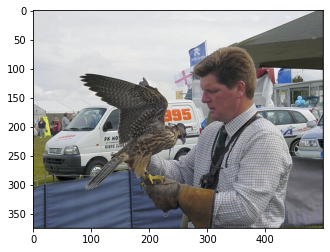

In [47]:
generate_caption(2, unq_valid_imgs.iloc[20]['image'])



Predicted caption : 
the man with black shirt and sunglasses is wearing glasses .


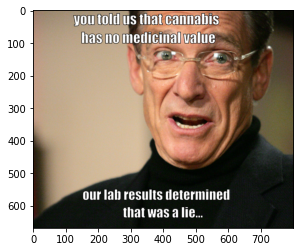

In [58]:
generate_caption_test(3, unq_test_imgs.iloc[34]['image'])

In [ ]:
generate_caption_test(3, unq_test_imgs.iloc[34]['image'])

In [49]:
model.eval() 

results = pd.DataFrame({'image': [], 'gen_caption': []})

In [50]:
for i in range(len(test)):
    try:
        if not i%50: print(i)
        results = pd.concat([results, pd.DataFrame({'image': [unq_test_imgs.iloc[i]['image']], 
                                                'gen_caption': [get_caption(1, unq_test_imgs.iloc[i]['image'])]})], 
                            ignore_index=True)
    except:
        print("Error occured at: ", i)

0
50
100
150
200
250
Error occured at:  256
300
350
Error occured at:  381
Error occured at:  392
400
Error occured at:  438
450
500
550
600
650
700
Error occured at:  737
Error occured at:  742
750
800
850
900
950
1000
1050
1100
1150
Error occured at:  1157
1200
1250
1300
1350
1400
Error occured at:  1414
1450
1500
Error occured at:  1510
1550
1600
Error occured at:  1649
1650
1700
Error occured at:  1734
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
Error occured at:  2498
2500
2550
2600
Error occured at:  2635
2650
Error occured at:  2689
2700
2750
2800
Error occured at:  2842
2850
2900
2950
3000
3050
Error occured at:  3057
3100
3150
Error occured at:  3160
Error occured at:  3161
3200
3250
3300
3350
3400
Error occured at:  3402
3450
Error occured at:  3481
3500
Error occured at:  3516
3550
Error occured at:  3596
3600
3650
3700
3750
3800
3850
3900
3950
4000
Error occured at:  4043
4050
4100
4150
4200
4250
4300
4350
4400
Error occured at:  4449
4450
450

In [51]:
unq_ress = results.drop_duplicates()
unq_ress

,image,gen_caption
0,52691.png,group of people are standing in front of crowd .
1,37825.png,man and woman are smiling and holding up sign .
2,06781.png,two little girls are standing in front of colorful wall .
3,49075.png,man in blue jacket is standing in front of tent .
4,73516.png,young boy with his eyes closed .
...,...,...
9851,98637.png,three people are in yellow and black and yellow shirt are standing in front of an orange and yellow and yellow and yellow and yellow and yellow and two people .
9852,04356.png,woman in black and white cap is smiling .
9853,65931.png,two men are standing in front of large crowd of people .
9854,60132.png,man in black shirt and white pants is standing in front of white building .


In [52]:
unq_ress.to_csv("./FHM_image_captions.csv", index=False)

In [53]:
dev_json = pd.read_json('/kaggle/input/facebook-hateful-meme-dataset/data/dev.jsonl',lines=True)
train_json = pd.read_json('/kaggle/input/facebook-hateful-meme-dataset/data/dev.jsonl',lines=True)
test_json = pd.read_json('/kaggle/input/facebook-hateful-meme-dataset/data/test.jsonl',lines=True)
combined_json = pd.concat([dev_json,train_json],axis=0)
combined_json[['img1','img2']] = combined_json['img'].str.split('/', expand=True)
combined_json.drop(['img','img1'], axis=1, inplace=True)
combined_json['img'] = combined_json['img2']
combined_json.drop(['img2','id'], axis=1, inplace=True)
final = combined_json.merge(unq_ress,left_on='img',right_on='image',how='inner')
final.head()

,label,text,img,image,gen_caption
0,1,white people is this a shooting range,08291.png,08291.png,two women in red shirts and black are sitting on the ground .
1,1,white people is this a shooting range,08291.png,08291.png,two women in red shirts and black are sitting on the ground .
2,1,bravery at its finest,46971.png,46971.png,man and woman are standing in front of crowd .
3,1,bravery at its finest,46971.png,46971.png,man and woman are standing in front of crowd .
4,1,your order comes to $37.50 and your white privilege discount brings the total to $37.50,03745.png,03745.png,woman in black shirt and white shirt is sitting on bench .


In [54]:
final.to_csv("./FHM_final.csv", index=False)

In [55]:
df = pd.read_csv("/kaggle/working/FHM_final.csv")

In [56]:
df

,label,text,img,image,gen_caption
0,1,white people is this a shooting range,08291.png,08291.png,two women in red shirts and black are sitting on the ground .
1,1,white people is this a shooting range,08291.png,08291.png,two women in red shirts and black are sitting on the ground .
2,1,bravery at its finest,46971.png,46971.png,man and woman are standing in front of crowd .
3,1,bravery at its finest,46971.png,46971.png,man and woman are standing in front of crowd .
4,1,your order comes to $37.50 and your white privilege discount brings the total to $37.50,03745.png,03745.png,woman in black shirt and white shirt is sitting on bench .
...,...,...,...,...,...
979,0,look at this sandwich maker club i found on wish on clearance,48670.png,48670.png,the blonde haired dog is eating sign .
980,0,diverse group of women,09863.png,09863.png,two girls are posing for picture .
981,0,diverse group of women,09863.png,09863.png,two girls are posing for picture .
982,0,"""when your dishwasher is broken so you take it back to walmart to get a new one""",97320.png,97320.png,person in white cap and black pants is climbing up snow covered wall .


In [57]:
df.head(6)

,label,text,img,image,gen_caption
0,1,white people is this a shooting range,08291.png,08291.png,two women in red shirts and black are sitting on the ground .
1,1,white people is this a shooting range,08291.png,08291.png,two women in red shirts and black are sitting on the ground .
2,1,bravery at its finest,46971.png,46971.png,man and woman are standing in front of crowd .
3,1,bravery at its finest,46971.png,46971.png,man and woman are standing in front of crowd .
4,1,your order comes to $37.50 and your white privilege discount brings the total to $37.50,03745.png,03745.png,woman in black shirt and white shirt is sitting on bench .
5,1,your order comes to $37.50 and your white privilege discount brings the total to $37.50,03745.png,03745.png,woman in black shirt and white shirt is sitting on bench .
